In [1]:
import numpy as np
import cupy as cp
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Inspect data

In [2]:
! head store/data.csv

0.233449,0.166667,0.381818,0.424594,0.164110,0.354839,0.250000,0.325581,0.166184,0.192771,6.000000
0.160279,0.196078,0.263636,0.262181,0.176380,0.161290,0.346154,0.255814,0.196453,0.301205,5.000000
0.083624,0.156863,0.300000,0.396752,0.191718,0.177419,0.355769,0.360465,0.226141,0.186747,6.000000
0.097561,0.107843,0.390909,0.201856,0.019939,0.451613,0.288462,0.372093,0.088490,0.216867,7.000000
0.073171,0.411765,0.445455,0.271462,0.007669,0.467742,0.413462,0.232558,0.128976,0.283133,5.000000
0.111498,0.235294,0.454545,0.197216,0.062883,0.822581,0.201923,0.406977,0.048775,0.168675,7.000000
0.024390,0.107843,0.309091,0.213457,0.015337,0.500000,0.442308,0.500000,0.132832,0.253012,4.000000
0.118467,0.127451,0.363636,0.262181,0.151840,0.419355,0.326923,0.209302,0.147869,0.186747,6.000000
0.108014,0.225490,0.290909,0.248260,0.185583,0.387097,0.298077,0.500000,0.159823,0.198795,6.000000
0.149826,0.137255,0.445455,0.357309,0.214724,0.096774,0.403846,0.546512,0.254290,0.253012,7.000000


## Parse data

In [3]:
import pandas as pd

df = pd.read_csv('store/data.csv', header=None)
df.columns = [ f'feat{i:1d}' for i in range(10) ] + ['label']
df.label = df.label.astype(int)
df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,label
0,0.233449,0.166667,0.381818,0.424594,0.164110,0.354839,0.250000,0.325581,0.166184,0.192771,6
1,0.160279,0.196078,0.263636,0.262181,0.176380,0.161290,0.346154,0.255814,0.196453,0.301205,5
2,0.083624,0.156863,0.300000,0.396752,0.191718,0.177419,0.355769,0.360465,0.226141,0.186747,6
3,0.097561,0.107843,0.390909,0.201856,0.019939,0.451613,0.288462,0.372093,0.088490,0.216867,7
4,0.073171,0.411765,0.445455,0.271462,0.007669,0.467742,0.413462,0.232558,0.128976,0.283133,5
...,...,...,...,...,...,...,...,...,...,...,...
3995,0.216028,0.098039,0.372727,0.415313,0.141104,0.419355,0.288462,0.337209,0.155966,0.144578,6
3996,0.202091,0.147059,0.400000,0.375870,0.243865,0.177419,0.317308,0.430233,0.229227,0.210843,6
3997,0.111498,0.156863,0.727273,0.278422,0.087423,0.387097,0.211538,0.220930,0.144399,0.192771,5
3998,0.052265,0.215686,0.463636,0.292343,0.058282,0.677419,0.250000,0.255814,0.103913,0.162651,6


# Train test split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming df is your DataFrame containing features and labels

# Splitting the dataset into features (X) and labels (y)
full_x, full_y = df.drop(columns='label'), df['label']

# Converting features and labels to PyTorch tensors
full_x = torch.tensor(np.array(full_x)).float()
full_y = torch.tensor(np.array(full_y)).long()

# Splitting the dataset into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(full_x, full_y, stratify=full_y, 
                                                  random_state=42, test_size=.2)


# Define models

In [5]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Constants for main arguments
BATCH_SIZE = 64           # Batch size for training and validation
HIDDEN_DIMENSION = 2048   # Dimensionality of the hidden layer

# Define the Multi-Layer Perceptron (MLP) model
class MLP(nn.Module):
    def __init__(self, n_feat, n_hid, n_out) -> None:
        super().__init__()

        # Layer declarations
        self.norm = nn.BatchNorm1d(n_feat)  # Batch normalization layer (we add this to AVOID having to normalize inputs!)
        self.ff1 = nn.Linear(n_feat, n_hid)  # Fully connected layer 1
        self.ff2 = nn.Linear(n_hid, n_hid)   # Fully connected layer 2
        self.out = nn.Linear(n_hid, n_out)   # Output layer

    def forward(self, x):
        # Forward pass of the model
        x = self.norm(x)                    # Batch normalization
        x = F.relu(self.ff1(x))             # ReLU activation on the first hidden layer
        x = F.relu(self.ff2(x))             # ReLU activation on the second hidden layer
        x = self.out(x)                     # Output layer
        return x
    
# Determine the device to use for training (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Assuming train_x, train_y, val_x, and val_y are already defined
n_samp, n_feat = train_x.shape

# Instantiate the MLP model
model = MLP(n_feat, n_hid=HIDDEN_DIMENSION, n_out=10)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Create TensorDatasets for training and validation sets
train_ds = TensorDataset(train_x, train_y)
val_ds = TensorDataset(val_x, val_y)

# Create DataLoaders for training and validation sets
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

# Double batch size for validation, since we don't keep activations around anymore
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE * 2)  

# Perform training

In [6]:


def train(data, model, loss_fn, optimizer, device):
    model.train()
    for step, (X, y) in enumerate(data):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if step % 20 == 0:
            loss, current = loss.item(), (step + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{step:>5d}]")

def eval(data, model, loss_fn, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    accuracy = correct / total
    avg_loss = total_loss / len(data)
    print(f'Accuracy: {accuracy}, Average Loss: {avg_loss}')
    return accuracy


epochs = 10

perf = []
for device in ['cpu', 'cuda']:
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

    print(f"Device: {device}")

    # Training
    start_time = time.time()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train(train_dl, model, loss_fn, optimizer, device=device)
        print("")
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time on {device}: {training_time} seconds")
    print("")

    # Inference
    start_time = time.time()
    eval(val_dl, model, loss_fn, device=device)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference Time on {device}: {inference_time} seconds")
    print("")

    perf.append({'Device': device, 'Training Time': training_time, 'Inference Time': inference_time})

Device: cpu
Epoch 1
-------------------------------
loss: 2.271462  [   64/    0]
loss: 1.104309  [ 1344/   20]
loss: 1.246969  [ 2624/   40]

Epoch 2
-------------------------------
loss: 1.010337  [   64/    0]
loss: 1.014078  [ 1344/   20]
loss: 1.072101  [ 2624/   40]

Epoch 3
-------------------------------
loss: 0.903971  [   64/    0]
loss: 1.041512  [ 1344/   20]
loss: 0.956172  [ 2624/   40]

Epoch 4
-------------------------------
loss: 0.889512  [   64/    0]
loss: 1.258786  [ 1344/   20]
loss: 1.098261  [ 2624/   40]

Epoch 5
-------------------------------
loss: 0.775062  [   64/    0]
loss: 0.801880  [ 1344/   20]
loss: 1.166527  [ 2624/   40]

Epoch 6
-------------------------------
loss: 1.144104  [   64/    0]
loss: 0.858723  [ 1344/   20]
loss: 1.000104  [ 2624/   40]

Epoch 7
-------------------------------
loss: 0.943017  [   64/    0]
loss: 0.959972  [ 1344/   20]
loss: 1.005030  [ 2624/   40]

Epoch 8
-------------------------------
loss: 0.920140  [   64/    0]
l

# Performance comparisons

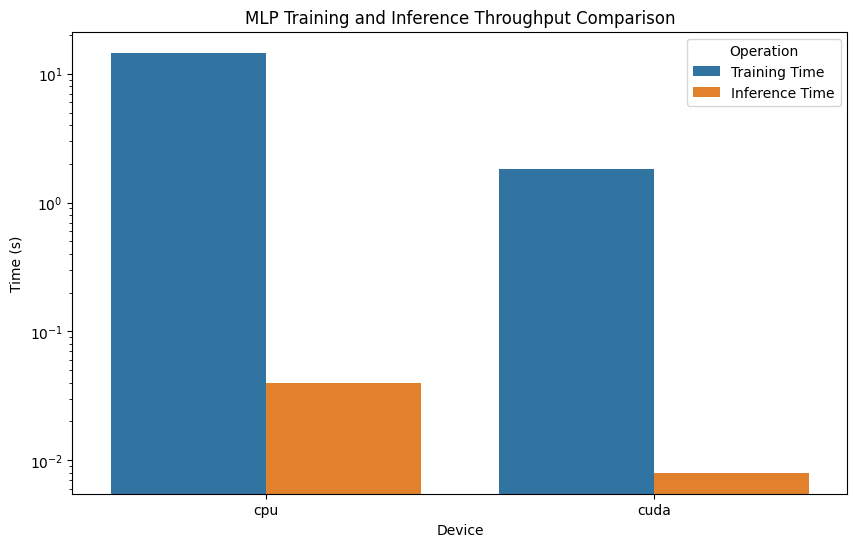

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(perf)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Device', y='Throughput', hue='Operation', data=pd.melt(df, id_vars=['Device'], 
                                                                      value_vars=['Training Time', 'Inference Time'], 
                                                                      var_name='Operation', value_name='Throughput'))
plt.title('MLP Training and Inference Throughput Comparison')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.xlabel('Device')
plt.show()